In [3]:
import os
import glob
import xarray as xr
import numpy as np
from scipy.signal import savgol_filter
import pandas as pd
import netCDF4 as nc
from datetime import datetime, timedelta
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

### SG filter

In [2]:
# Define Savitzky-Golay filter parameters
window_length = 12  # Must be an odd number
polyorder     = 2       # Order of the polynomial

# file_in  = "/g/data/w97/mm3972/data/MODIS/MODIS_LAI/AUS/regrid_2_AWAP_5km/MCD15A3H.061_500m_aid0001_LAI_regridded_2002-2024.nc"
# file_out = f"/g/data/w97/mm3972/data/MODIS/MODIS_LAI/AUS/regrid_2_AWAP_5km/MCD15A3H.061_500m_aid0001_LAI_regridded_2002-2024_SG_filter_window={window_length}_order={polyorder}.nc"

file_in  = "/g/data/w97/mm3972/data/MODIS/MODIS_LAI/AUS/regrid_2_AWAP_5km/MCD15A3H.061_500m_aid0001_2016-2020_LAI_fix_regridded.nc"
file_out = f"/g/data/w97/mm3972/data/MODIS/MODIS_LAI/AUS/regrid_2_AWAP_5km/MCD15A3H.061_500m_aid0001_2016-2020_LAI_fix_regridded_window={window_length}_order={polyorder}.nc"

# Load the NetCDF file into an xarray Dataset
ds = xr.open_dataset(file_in, engine="netcdf4")

# Chunk the dataset along 'lat' and 'lon' dimensions
# Example chunk sizes: 50 for lat and lon, time remains unchunked
ds_chunked = ds.chunk({"time": -1, "latitude": 50, "longitude": 50})

# Extract the LAI array
lai        = ds_chunked["Lai_500m"]
print(lai.chunks)  # Verify chunking

# Apply the filter along the time dimension
smoothed_lai = xr.apply_ufunc(
    savgol_filter,
    lai,                # First argument: has a "time" dimension
    window_length,      # Second argument: scalar, no dimensions
    polyorder,          # Third argument: scalar, no dimensions
    kwargs={"axis": 0},  # Smooth along the time dimension
    # input_core_dims=[["time"], [], []],  # One entry per argument, for my case savgol_filter(lai, window_length,polyorder), ["time"] is for lai, the two [] are for window_length and polyorder
    # output_core_dims=[["time"]],         # Output has a "time" dimension
    input_core_dims=[["time"], [], []],  # One entry per argument, for my case savgol_filter(lai, window_length,polyorder), ["time"] is for lai, the two [] are for window_length and polyorder
    output_core_dims=[["time"]],         # Output has a "time" dimension
    vectorize=True,                      # Enable vectorization
    dask="parallelized",                 # Use Dask if data is chunked
    output_dtypes=[lai.dtype],           # Keep the same data type
)

# Copy the attributes from Lai_500m to the smoothed version
smoothed_lai.attrs = lai.attrs.copy()

# Remove the 'Lai_500m' variable from the dataset
ds_chunked         = ds_chunked.drop("Lai_500m")

# Rename the smoothed variable to "Lai_500m"
smoothed_lai.name  = "Lai_500m"

# Reorder the dimensions to (time, lat, lon)
smoothed_lai       = smoothed_lai.transpose("time", "latitude", "longitude")

# Add the smoothed data back to the Dataset
ds_chunked["Lai_500m"] = smoothed_lai

# Check if the file exists
if os.path.exists(file_out):
     os.remove(file_out)
    
# Save to a new NetCDF file
ds_chunked.to_netcdf(file_out)

print(f"Smoothed LAI saved to {file_out}")


# return


/home/561/mm3972/.local/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'argo' loading failed:
cannot import name 'validate_key' from 'dask.core' (/home/561/mm3972/.local/lib/python3.10/site-packages/dask/core.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


((460,), (50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 31), (50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 41))
Smoothed LAI saved to /g/data/w97/mm3972/data/MODIS/MODIS_LAI/AUS/regrid_2_AWAP_5km/MCD15A3H.061_500m_aid0001_2016-2020_LAI_fix_regridded_window=12_order=2.nc


In [5]:
# Reorder the dimensions to (time, lat, lon)
smoothed_lai = smoothed_lai.transpose("time", "latitude", "longitude")

In [6]:
smoothed_lai

,Array,Chunk
Bytes,0.98 GiB,4.39 MiB
Shape,"(460, 681, 841)","(460, 50, 50)"
Count,1431 Tasks,238 Chunks
Type,float32,numpy.ndarray


### Compare original & sg filtered LAI 

In [4]:
def get_PLUMBER2_lat_lon_LAI(PLUMBER2_AU_file, au_site_list, start_date, end_date):

    site_name  = PLUMBER2_AU_file.split('_')[0] 
    print(site_name)

    # Read PLUMBER2 file
    f_PLUMBER2 = nc.Dataset(f'{PLUMBER2_path}/{PLUMBER2_AU_file}') 

    df_P2      = pd.DataFrame(f_PLUMBER2.variables['LAI'][:,0,0].data, columns=['LAI'])

    # Read PLUMBER2 time
    P2_time    = nc.num2date(f_PLUMBER2.variables['time'][:], 
                             f_PLUMBER2.variables['time'].units, 
                             only_use_cftime_datetimes=False,
                             only_use_python_datetimes=True)
        
    ntime = len(P2_time)
    year  = np.zeros(ntime)
    month = np.zeros(ntime)
    day   = np.zeros(ntime)
    
    # Extract year, month, day
    for tt, t in enumerate(P2_time):
        year[tt]  = t.year
        month[tt] = t.month
        day[tt]   = t.day

    # Make time array for processed LAI  
    start_date_P2  = datetime(int(year[0]),  int(month[0]),  int(day[0]), 0, 0)
    end_date_P2    = datetime(int(year[-1]), int(month[-1]), int(day[-1]), 0, 0)

    # Create an array of datetime objects
    P2_time_new    = np.array([start_date_P2 + timedelta(days=i) for i in range((end_date_P2 - start_date_P2).days + 1)])
    
    time_mask      = (P2_time_new>=start_date) & (P2_time_new<=end_date)
    
    if np.sum(time_mask)>10:

        df_P2['year']  = year
        df_P2['month'] = month
        df_P2['day']   = day
        df_P2          = df_P2.groupby(['year', 'month', 'day']).mean(numeric_only=True).reset_index()

        # Get lat and lon for the site
        lat = au_site_characters.loc[au_site_characters['site_name'] == site_name, 'lat'].values[0]
        lon = au_site_characters.loc[au_site_characters['site_name'] == site_name, 'lon'].values[0]
        # print(lat, lon)

        df_P2_tmp         = df_P2.loc[time_mask]
        df_P2_tmp['time'] = P2_time_new[time_mask]

        return site_name, lat, lon, df_P2_tmp
    else:
        return site_name, np.nan, np.nan, np.nan

AU-ASM


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-22.28300094604492 133.24899291992188         year  month   day       LAI       time
1826  2016.0    1.0   1.0  0.316122 2016-01-01
1827  2016.0    1.0   2.0  0.316122 2016-01-02
1828  2016.0    1.0   3.0  0.316122 2016-01-03
1829  2016.0    1.0   4.0  0.316122 2016-01-04
1830  2016.0    1.0   5.0  0.316122 2016-01-05
...      ...    ...   ...       ...        ...
2187  2016.0   12.0  27.0  0.511213 2016-12-27
2188  2016.0   12.0  28.0  0.511213 2016-12-28
2189  2016.0   12.0  29.0  0.511213 2016-12-29
2190  2016.0   12.0  30.0  0.511213 2016-12-30
2191  2016.0   12.0  31.0  0.511213 2016-12-31

[366 rows x 5 columns]
91 91 366
AU-Cpr


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-34.00205993652344 140.58912658691406         year  month   day       LAI       time
1826  2016.0    1.0   1.0  0.341463 2016-01-01
1827  2016.0    1.0   2.0  0.341463 2016-01-02
1828  2016.0    1.0   3.0  0.341463 2016-01-03
1829  2016.0    1.0   4.0  0.341463 2016-01-04
1830  2016.0    1.0   5.0  0.341463 2016-01-05
...      ...    ...   ...       ...        ...
2187  2016.0   12.0  27.0  0.395362 2016-12-27
2188  2016.0   12.0  28.0  0.395362 2016-12-28
2189  2016.0   12.0  29.0  0.395362 2016-12-29
2190  2016.0   12.0  30.0  0.395362 2016-12-30
2191  2016.0   12.0  31.0  0.395362 2016-12-31

[366 rows x 5 columns]
91 91 366
AU-Cum


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-33.61329650878906 150.72247314453125         year  month   day       LAI       time
1095  2016.0    1.0   1.0  1.879353 2016-01-01
1096  2016.0    1.0   2.0  1.879353 2016-01-02
1097  2016.0    1.0   3.0  1.879353 2016-01-03
1098  2016.0    1.0   4.0  1.879353 2016-01-04
1099  2016.0    1.0   5.0  1.879353 2016-01-05
...      ...    ...   ...       ...        ...
1456  2016.0   12.0  27.0  1.411287 2016-12-27
1457  2016.0   12.0  28.0  1.411287 2016-12-28
1458  2016.0   12.0  29.0  1.411287 2016-12-29
1459  2016.0   12.0  30.0  1.411287 2016-12-30
1460  2016.0   12.0  31.0  1.411287 2016-12-31

[366 rows x 5 columns]
91 91 366
AU-DaP
nan nan nan
AU-DaS


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-14.159282684326172 131.38800048828125         year  month   day       LAI       time
2191  2016.0    1.0   1.0  1.746585 2016-01-01
2192  2016.0    1.0   2.0  1.746585 2016-01-02
2193  2016.0    1.0   3.0  1.746585 2016-01-03
2194  2016.0    1.0   4.0  1.746585 2016-01-04
2195  2016.0    1.0   5.0  1.746585 2016-01-05
...      ...    ...   ...       ...        ...
2552  2016.0   12.0  27.0  1.303995 2016-12-27
2553  2016.0   12.0  28.0  1.303995 2016-12-28
2554  2016.0   12.0  29.0  1.303995 2016-12-29
2555  2016.0   12.0  30.0  1.303995 2016-12-30
2556  2016.0   12.0  31.0  1.303995 2016-12-31

[366 rows x 5 columns]
91 91 366
AU-Dry
nan nan nan
AU-Emr
nan nan nan
AU-GWW


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-30.19129943847656 120.6540985107422         year  month   day       LAI       time
1095  2016.0    1.0   1.0  0.452276 2016-01-01
1096  2016.0    1.0   2.0  0.452276 2016-01-02
1097  2016.0    1.0   3.0  0.452276 2016-01-03
1098  2016.0    1.0   4.0  0.452276 2016-01-04
1099  2016.0    1.0   5.0  0.452276 2016-01-05
...      ...    ...   ...       ...        ...
1456  2016.0   12.0  27.0  0.469282 2016-12-27
1457  2016.0   12.0  28.0  0.469282 2016-12-28
1458  2016.0   12.0  29.0  0.469282 2016-12-29
1459  2016.0   12.0  30.0  0.469282 2016-12-30
1460  2016.0   12.0  31.0  0.469282 2016-12-31

[366 rows x 5 columns]
91 91 366
AU-Gin


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-31.375 115.6500015258789         year  month   day       LAI       time
1461  2016.0    1.0   1.0  0.877529 2016-01-01
1462  2016.0    1.0   2.0  0.877529 2016-01-02
1463  2016.0    1.0   3.0  0.877529 2016-01-03
1464  2016.0    1.0   4.0  0.877529 2016-01-04
1465  2016.0    1.0   5.0  0.877529 2016-01-05
...      ...    ...   ...       ...        ...
1822  2016.0   12.0  27.0  1.097944 2016-12-27
1823  2016.0   12.0  28.0  1.097944 2016-12-28
1824  2016.0   12.0  29.0  1.097944 2016-12-29
1825  2016.0   12.0  30.0  1.097944 2016-12-30
1826  2016.0   12.0  31.0  1.097944 2016-12-31

[366 rows x 5 columns]
91 91 366
AU-How


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-12.495200157165527 131.14999389648438         year  month   day       LAI       time
4748  2016.0    1.0   1.0  2.334288 2016-01-01
4749  2016.0    1.0   2.0  2.334288 2016-01-02
4750  2016.0    1.0   3.0  2.334288 2016-01-03
4751  2016.0    1.0   4.0  2.334288 2016-01-04
4752  2016.0    1.0   5.0  2.334288 2016-01-05
...      ...    ...   ...       ...        ...
5109  2016.0   12.0  27.0  2.453997 2016-12-27
5110  2016.0   12.0  28.0  2.453997 2016-12-28
5111  2016.0   12.0  29.0  2.453997 2016-12-29
5112  2016.0   12.0  30.0  2.453997 2016-12-30
5113  2016.0   12.0  31.0  2.453997 2016-12-31

[366 rows x 5 columns]
91 91 366
AU-Lit
-13.17903995513916 130.79449462890625        year  month   day       LAI       time
0    2016.0    1.0   1.0  2.252496 2016-01-01
1    2016.0    1.0   2.0  2.252496 2016-01-02
2    2016.0    1.0   3.0  2.252496 2016-01-03
3    2016.0    1.0   4.0  2.252496 2016-01-04
4    2016.0    1.0   5.0  2.252496 2016-01-05
..      ...    ...   ...       ...        

/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

91 91 366
AU-Rig


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-36.649898529052734 145.57589721679688         year  month   day       LAI       time
1826  2016.0    1.0   1.0  0.436615 2016-01-01
1827  2016.0    1.0   2.0  0.436615 2016-01-02
1828  2016.0    1.0   3.0  0.436615 2016-01-03
1829  2016.0    1.0   4.0  0.436615 2016-01-04
1830  2016.0    1.0   5.0  0.436615 2016-01-05
...      ...    ...   ...       ...        ...
2187  2016.0   12.0  27.0  0.623554 2016-12-27
2188  2016.0   12.0  28.0  0.623554 2016-12-28
2189  2016.0   12.0  29.0  0.623554 2016-12-29
2190  2016.0   12.0  30.0  0.623554 2016-12-30
2191  2016.0   12.0  31.0  0.623554 2016-12-31

[366 rows x 5 columns]
91 91 366
AU-Rob


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-17.11750030517578 145.63009643554688         year  month   day       LAI       time
730   2016.0    1.0   1.0  6.170599 2016-01-01
731   2016.0    1.0   2.0  6.170599 2016-01-02
732   2016.0    1.0   3.0  6.170599 2016-01-03
733   2016.0    1.0   4.0  6.170599 2016-01-04
734   2016.0    1.0   5.0  6.170599 2016-01-05
...      ...    ...   ...       ...        ...
1091  2016.0   12.0  27.0  6.168854 2016-12-27
1092  2016.0   12.0  28.0  6.168854 2016-12-28
1093  2016.0   12.0  29.0  6.168854 2016-12-29
1094  2016.0   12.0  30.0  6.168854 2016-12-30
1095  2016.0   12.0  31.0  6.168854 2016-12-31

[366 rows x 5 columns]
91 91 366
AU-Sam


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-27.38809967041016 152.8778076171875         year  month   day       LAI       time
1826  2016.0    1.0   1.0  1.838417 2016-01-01
1827  2016.0    1.0   2.0  1.838417 2016-01-02
1828  2016.0    1.0   3.0  1.838417 2016-01-03
1829  2016.0    1.0   4.0  1.838417 2016-01-04
1830  2016.0    1.0   5.0  1.838417 2016-01-05
...      ...    ...   ...       ...        ...
2187  2016.0   12.0  27.0  1.899008 2016-12-27
2188  2016.0   12.0  28.0  1.899008 2016-12-28
2189  2016.0   12.0  29.0  1.899008 2016-12-29
2190  2016.0   12.0  30.0  1.899008 2016-12-30
2191  2016.0   12.0  31.0  1.899008 2016-12-31

[366 rows x 5 columns]
91 91 366
AU-Stp


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-17.150699615478516 133.35020446777344         year  month   day       LAI       time
2191  2016.0    1.0   1.0  0.838116 2016-01-01
2192  2016.0    1.0   2.0  0.838116 2016-01-02
2193  2016.0    1.0   3.0  0.838116 2016-01-03
2194  2016.0    1.0   4.0  0.838116 2016-01-04
2195  2016.0    1.0   5.0  0.838116 2016-01-05
...      ...    ...   ...       ...        ...
2552  2016.0   12.0  27.0  0.651632 2016-12-27
2553  2016.0   12.0  28.0  0.651632 2016-12-28
2554  2016.0   12.0  29.0  0.651632 2016-12-29
2555  2016.0   12.0  30.0  0.651632 2016-12-30
2556  2016.0   12.0  31.0  0.651632 2016-12-31

[366 rows x 5 columns]
91 91 366
AU-TTE


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-22.28700065612793 133.63999938964844         year  month   day       LAI       time
1095  2016.0    1.0   1.0  0.388899 2016-01-01
1096  2016.0    1.0   2.0  0.388899 2016-01-02
1097  2016.0    1.0   3.0  0.388899 2016-01-03
1098  2016.0    1.0   4.0  0.388899 2016-01-04
1099  2016.0    1.0   5.0  0.388899 2016-01-05
...      ...    ...   ...       ...        ...
1456  2016.0   12.0  27.0  0.506227 2016-12-27
1457  2016.0   12.0  28.0  0.506227 2016-12-28
1458  2016.0   12.0  29.0  0.506227 2016-12-29
1459  2016.0   12.0  30.0  0.506227 2016-12-30
1460  2016.0   12.0  31.0  0.506227 2016-12-31

[366 rows x 5 columns]
91 91 366
AU-Tum


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-35.65660095214844 148.15170288085938         year  month   day       LAI       time
5113  2016.0    1.0   1.0  4.063846 2016-01-01
5114  2016.0    1.0   2.0  4.063846 2016-01-02
5115  2016.0    1.0   3.0  4.063846 2016-01-03
5116  2016.0    1.0   4.0  4.063846 2016-01-04
5117  2016.0    1.0   5.0  4.063846 2016-01-05
...      ...    ...   ...       ...        ...
5474  2016.0   12.0  27.0  4.384536 2016-12-27
5475  2016.0   12.0  28.0  4.384536 2016-12-28
5476  2016.0   12.0  29.0  4.384536 2016-12-29
5477  2016.0   12.0  30.0  4.384536 2016-12-30
5478  2016.0   12.0  31.0  4.384536 2016-12-31

[366 rows x 5 columns]
91 91 366
AU-Whr


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-36.67319869995117 145.02940368652344        year  month   day       LAI       time
365  2016.0    1.0   1.0  1.127230 2016-01-01
366  2016.0    1.0   2.0  1.127230 2016-01-02
367  2016.0    1.0   3.0  1.127230 2016-01-03
368  2016.0    1.0   4.0  1.127230 2016-01-04
369  2016.0    1.0   5.0  1.127230 2016-01-05
..      ...    ...   ...       ...        ...
726  2016.0   12.0  27.0  1.536888 2016-12-27
727  2016.0   12.0  28.0  1.536888 2016-12-28
728  2016.0   12.0  29.0  1.536888 2016-12-29
729  2016.0   12.0  30.0  1.536888 2016-12-30
730  2016.0   12.0  31.0  1.536888 2016-12-31

[366 rows x 5 columns]
91 91 366
AU-Wrr


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-43.09502029418945 146.6544952392578        year  month   day       LAI       time
0    2016.0    1.0   1.0  4.102516 2016-01-01
1    2016.0    1.0   2.0  4.102516 2016-01-02
2    2016.0    1.0   3.0  4.102516 2016-01-03
3    2016.0    1.0   4.0  4.102516 2016-01-04
4    2016.0    1.0   5.0  4.102516 2016-01-05
..      ...    ...   ...       ...        ...
361  2016.0   12.0  27.0  3.699681 2016-12-27
362  2016.0   12.0  28.0  3.699681 2016-12-28
363  2016.0   12.0  29.0  3.699681 2016-12-29
364  2016.0   12.0  30.0  3.699681 2016-12-30
365  2016.0   12.0  31.0  3.699681 2016-12-31

[366 rows x 5 columns]
91 91 366
AU-Ync


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-34.98929977416992 146.2906951904297         year  month   day       LAI       time
1826  2016.0    1.0   1.0  0.504304 2016-01-01
1827  2016.0    1.0   2.0  0.504304 2016-01-02
1828  2016.0    1.0   3.0  0.504304 2016-01-03
1829  2016.0    1.0   4.0  0.504304 2016-01-04
1830  2016.0    1.0   5.0  0.504304 2016-01-05
...      ...    ...   ...       ...        ...
2187  2016.0   12.0  27.0  0.630304 2016-12-27
2188  2016.0   12.0  28.0  0.630304 2016-12-28
2189  2016.0   12.0  29.0  0.630304 2016-12-29
2190  2016.0   12.0  30.0  0.630304 2016-12-30
2191  2016.0   12.0  31.0  0.630304 2016-12-31

[366 rows x 5 columns]
91 91 366
AU-ASM


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-22.28300094604492 133.24899291992188         year  month   day       LAI       time
2192  2017.0    1.0   1.0  0.594292 2017-01-01
2193  2017.0    1.0   2.0  0.594292 2017-01-02
2194  2017.0    1.0   3.0  0.594292 2017-01-03
2195  2017.0    1.0   4.0  0.594292 2017-01-04
2196  2017.0    1.0   5.0  0.594292 2017-01-05
...      ...    ...   ...       ...        ...
2552  2017.0   12.0  27.0  0.324900 2017-12-27
2553  2017.0   12.0  28.0  0.324900 2017-12-28
2554  2017.0   12.0  29.0  0.324900 2017-12-29
2555  2017.0   12.0  30.0  0.324900 2017-12-30
2556  2017.0   12.0  31.0  0.324900 2017-12-31

[365 rows x 5 columns]
92 92 365
AU-Cpr


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-34.00205993652344 140.58912658691406         year  month   day       LAI       time
2192  2017.0    1.0   1.0  0.402071 2017-01-01
2193  2017.0    1.0   2.0  0.402071 2017-01-02
2194  2017.0    1.0   3.0  0.402071 2017-01-03
2195  2017.0    1.0   4.0  0.402071 2017-01-04
2196  2017.0    1.0   5.0  0.402071 2017-01-05
...      ...    ...   ...       ...        ...
2552  2017.0   12.0  27.0  0.397372 2017-12-27
2553  2017.0   12.0  28.0  0.397372 2017-12-28
2554  2017.0   12.0  29.0  0.397372 2017-12-29
2555  2017.0   12.0  30.0  0.397372 2017-12-30
2556  2017.0   12.0  31.0  0.397372 2017-12-31

[365 rows x 5 columns]
92 92 365
AU-Cum


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-33.61329650878906 150.72247314453125         year  month   day       LAI       time
1461  2017.0    1.0   1.0  1.391806 2017-01-01
1462  2017.0    1.0   2.0  1.391806 2017-01-02
1463  2017.0    1.0   3.0  1.391806 2017-01-03
1464  2017.0    1.0   4.0  1.391806 2017-01-04
1465  2017.0    1.0   5.0  1.391806 2017-01-05
...      ...    ...   ...       ...        ...
1821  2017.0   12.0  27.0  1.523567 2017-12-27
1822  2017.0   12.0  28.0  1.523567 2017-12-28
1823  2017.0   12.0  29.0  1.523567 2017-12-29
1824  2017.0   12.0  30.0  1.523567 2017-12-30
1825  2017.0   12.0  31.0  1.523567 2017-12-31

[365 rows x 5 columns]
92 92 365
AU-DaP
nan nan nan
AU-DaS


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-14.159282684326172 131.38800048828125         year  month   day       LAI       time
2557  2017.0    1.0   1.0  1.338711 2017-01-01
2558  2017.0    1.0   2.0  1.338711 2017-01-02
2559  2017.0    1.0   3.0  1.338711 2017-01-03
2560  2017.0    1.0   4.0  1.338711 2017-01-04
2561  2017.0    1.0   5.0  1.338711 2017-01-05
...      ...    ...   ...       ...        ...
2917  2017.0   12.0  27.0  1.848722 2017-12-27
2918  2017.0   12.0  28.0  1.848722 2017-12-28
2919  2017.0   12.0  29.0  1.848722 2017-12-29
2920  2017.0   12.0  30.0  1.848722 2017-12-30
2921  2017.0   12.0  31.0  1.848722 2017-12-31

[365 rows x 5 columns]
92 92 365
AU-Dry
nan nan nan
AU-Emr
nan nan nan
AU-GWW


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-30.19129943847656 120.6540985107422         year  month   day       LAI       time
1461  2017.0    1.0   1.0  0.472110 2017-01-01
1462  2017.0    1.0   2.0  0.472110 2017-01-02
1463  2017.0    1.0   3.0  0.472110 2017-01-03
1464  2017.0    1.0   4.0  0.472110 2017-01-04
1465  2017.0    1.0   5.0  0.472110 2017-01-05
...      ...    ...   ...       ...        ...
1821  2017.0   12.0  27.0  0.476398 2017-12-27
1822  2017.0   12.0  28.0  0.476398 2017-12-28
1823  2017.0   12.0  29.0  0.476398 2017-12-29
1824  2017.0   12.0  30.0  0.476398 2017-12-30
1825  2017.0   12.0  31.0  0.476398 2017-12-31

[365 rows x 5 columns]
92 92 365
AU-Gin


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-31.375 115.6500015258789         year  month   day       LAI       time
1827  2017.0    1.0   1.0  1.101162 2017-01-01
1828  2017.0    1.0   2.0  1.101162 2017-01-02
1829  2017.0    1.0   3.0  1.101162 2017-01-03
1830  2017.0    1.0   4.0  1.101162 2017-01-04
1831  2017.0    1.0   5.0  1.101162 2017-01-05
...      ...    ...   ...       ...        ...
2187  2017.0   12.0  27.0  1.115779 2017-12-27
2188  2017.0   12.0  28.0  1.115779 2017-12-28
2189  2017.0   12.0  29.0  1.115779 2017-12-29
2190  2017.0   12.0  30.0  1.115779 2017-12-30
2191  2017.0   12.0  31.0  1.115779 2017-12-31

[365 rows x 5 columns]
92 92 365
AU-How


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-12.495200157165527 131.14999389648438         year  month   day       LAI       time
5114  2017.0    1.0   1.0  2.482793 2017-01-01
5115  2017.0    1.0   2.0  2.482793 2017-01-02
5116  2017.0    1.0   3.0  2.482793 2017-01-03
5117  2017.0    1.0   4.0  2.482793 2017-01-04
5118  2017.0    1.0   5.0  2.482793 2017-01-05
...      ...    ...   ...       ...        ...
5474  2017.0   12.0  27.0  2.286318 2017-12-27
5475  2017.0   12.0  28.0  2.286318 2017-12-28
5476  2017.0   12.0  29.0  2.286318 2017-12-29
5477  2017.0   12.0  30.0  2.286318 2017-12-30
5478  2017.0   12.0  31.0  2.286318 2017-12-31

[365 rows x 5 columns]
92 92 365
AU-Lit
-13.17903995513916 130.79449462890625        year  month   day       LAI       time
366  2017.0    1.0   1.0  2.223539 2017-01-01
367  2017.0    1.0   2.0  2.223539 2017-01-02
368  2017.0    1.0   3.0  2.223539 2017-01-03
369  2017.0    1.0   4.0  2.223539 2017-01-04
370  2017.0    1.0   5.0  2.223539 2017-01-05
..      ...    ...   ...       ...        

/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

AU-Rig
nan nan nan
AU-Rob


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-17.11750030517578 145.63009643554688         year  month   day       LAI       time
1096  2017.0    1.0   1.0  6.130366 2017-01-01
1097  2017.0    1.0   2.0  6.130366 2017-01-02
1098  2017.0    1.0   3.0  6.130366 2017-01-03
1099  2017.0    1.0   4.0  6.130366 2017-01-04
1100  2017.0    1.0   5.0  6.130366 2017-01-05
...      ...    ...   ...       ...        ...
1456  2017.0   12.0  27.0  6.154076 2017-12-27
1457  2017.0   12.0  28.0  6.154076 2017-12-28
1458  2017.0   12.0  29.0  6.154076 2017-12-29
1459  2017.0   12.0  30.0  6.154076 2017-12-30
1460  2017.0   12.0  31.0  6.154076 2017-12-31

[365 rows x 5 columns]
92 92 365
AU-Sam


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-27.38809967041016 152.8778076171875         year  month   day       LAI       time
2192  2017.0    1.0   1.0  2.118934 2017-01-01
2193  2017.0    1.0   2.0  2.118934 2017-01-02
2194  2017.0    1.0   3.0  2.118934 2017-01-03
2195  2017.0    1.0   4.0  2.118934 2017-01-04
2196  2017.0    1.0   5.0  2.118934 2017-01-05
...      ...    ...   ...       ...        ...
2552  2017.0   12.0  27.0  1.909135 2017-12-27
2553  2017.0   12.0  28.0  1.909135 2017-12-28
2554  2017.0   12.0  29.0  1.909135 2017-12-29
2555  2017.0   12.0  30.0  1.909135 2017-12-30
2556  2017.0   12.0  31.0  1.909135 2017-12-31

[365 rows x 5 columns]
92 92 365
AU-Stp


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-17.150699615478516 133.35020446777344         year  month   day       LAI       time
2557  2017.0    1.0   1.0  0.994899 2017-01-01
2558  2017.0    1.0   2.0  0.994899 2017-01-02
2559  2017.0    1.0   3.0  0.994899 2017-01-03
2560  2017.0    1.0   4.0  0.994899 2017-01-04
2561  2017.0    1.0   5.0  0.994899 2017-01-05
...      ...    ...   ...       ...        ...
2917  2017.0   12.0  27.0  0.511458 2017-12-27
2918  2017.0   12.0  28.0  0.511458 2017-12-28
2919  2017.0   12.0  29.0  0.511458 2017-12-29
2920  2017.0   12.0  30.0  0.511458 2017-12-30
2921  2017.0   12.0  31.0  0.511458 2017-12-31

[365 rows x 5 columns]
92 92 365
AU-TTE


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-22.28700065612793 133.63999938964844         year  month   day       LAI       time
1461  2017.0    1.0   1.0  0.537639 2017-01-01
1462  2017.0    1.0   2.0  0.537639 2017-01-02
1463  2017.0    1.0   3.0  0.537639 2017-01-03
1464  2017.0    1.0   4.0  0.537639 2017-01-04
1465  2017.0    1.0   5.0  0.537639 2017-01-05
...      ...    ...   ...       ...        ...
1821  2017.0   12.0  27.0  0.317695 2017-12-27
1822  2017.0   12.0  28.0  0.317695 2017-12-28
1823  2017.0   12.0  29.0  0.317695 2017-12-29
1824  2017.0   12.0  30.0  0.317695 2017-12-30
1825  2017.0   12.0  31.0  0.317695 2017-12-31

[365 rows x 5 columns]
92 92 365
AU-Tum


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-35.65660095214844 148.15170288085938         year  month   day       LAI       time
5479  2017.0    1.0   1.0  4.602157 2017-01-01
5480  2017.0    1.0   2.0  4.602157 2017-01-02
5481  2017.0    1.0   3.0  4.602157 2017-01-03
5482  2017.0    1.0   4.0  4.602157 2017-01-04
5483  2017.0    1.0   5.0  4.602157 2017-01-05
...      ...    ...   ...       ...        ...
5839  2017.0   12.0  27.0  3.479492 2017-12-27
5840  2017.0   12.0  28.0  3.479492 2017-12-28
5841  2017.0   12.0  29.0  3.479492 2017-12-29
5842  2017.0   12.0  30.0  3.479492 2017-12-30
5843  2017.0   12.0  31.0  3.479492 2017-12-31

[365 rows x 5 columns]
92 92 365
AU-Whr
nan nan nan
AU-Wrr


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-43.09502029418945 146.6544952392578        year  month   day       LAI       time
366  2017.0    1.0   1.0  3.698532 2017-01-01
367  2017.0    1.0   2.0  3.698532 2017-01-02
368  2017.0    1.0   3.0  3.698532 2017-01-03
369  2017.0    1.0   4.0  3.698532 2017-01-04
370  2017.0    1.0   5.0  3.698532 2017-01-05
..      ...    ...   ...       ...        ...
726  2017.0   12.0  27.0  3.531848 2017-12-27
727  2017.0   12.0  28.0  3.531848 2017-12-28
728  2017.0   12.0  29.0  3.531848 2017-12-29
729  2017.0   12.0  30.0  3.531848 2017-12-30
730  2017.0   12.0  31.0  3.531848 2017-12-31

[365 rows x 5 columns]
92 92 365
AU-Ync


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-34.98929977416992 146.2906951904297         year  month   day       LAI       time
2192  2017.0    1.0   1.0  0.454594 2017-01-01
2193  2017.0    1.0   2.0  0.454594 2017-01-02
2194  2017.0    1.0   3.0  0.454594 2017-01-03
2195  2017.0    1.0   4.0  0.454594 2017-01-04
2196  2017.0    1.0   5.0  0.454594 2017-01-05
...      ...    ...   ...       ...        ...
2552  2017.0   12.0  27.0  0.276021 2017-12-27
2553  2017.0   12.0  28.0  0.276021 2017-12-28
2554  2017.0   12.0  29.0  0.276021 2017-12-29
2555  2017.0   12.0  30.0  0.276021 2017-12-30
2556  2017.0   12.0  31.0  0.276021 2017-12-31

[365 rows x 5 columns]
92 92 365
AU-ASM
nan nan nan
AU-Cpr
nan nan nan
AU-Cum


/jobfs/128524831.gadi-pbs/ipykernel_669796/3675654166.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_P2_tmp['time'] = P2_time_new[time_mask]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]
/jobfs/128524831.gadi-pbs/ipykernel_669796/4147380838.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

-33.61329650878906 150.72247314453125         year  month   day       LAI       time
1826  2018.0    1.0   1.0  1.501288 2018-01-01
1827  2018.0    1.0   2.0  1.501288 2018-01-02
1828  2018.0    1.0   3.0  1.501288 2018-01-03
1829  2018.0    1.0   4.0  1.501288 2018-01-04
1830  2018.0    1.0   5.0  1.501288 2018-01-05
...      ...    ...   ...       ...        ...
2186  2018.0   12.0  27.0  1.815690 2018-12-27
2187  2018.0   12.0  28.0  1.815690 2018-12-28
2188  2018.0   12.0  29.0  1.815690 2018-12-29
2189  2018.0   12.0  30.0  1.815690 2018-12-30
2190  2018.0   12.0  31.0  1.815690 2018-12-31

[365 rows x 5 columns]
92 92 365
AU-DaP
nan nan nan
AU-DaS
nan nan nan
AU-Dry
nan nan nan
AU-Emr
nan nan nan
AU-GWW
nan nan nan
AU-Gin
nan nan nan
AU-How
nan nan nan
AU-Lit
nan nan nan
AU-Rig
nan nan nan
AU-Rob
nan nan nan
AU-Sam
nan nan nan
AU-Stp
nan nan nan
AU-TTE
nan nan nan
AU-Tum
nan nan nan
AU-Whr
nan nan nan
AU-Wrr
nan nan nan
AU-Ync
nan nan nan
AU-ASM
nan nan nan
AU-Cpr
nan nan nan
AU-

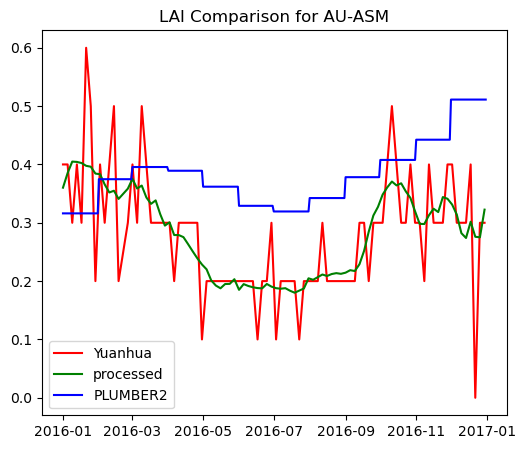

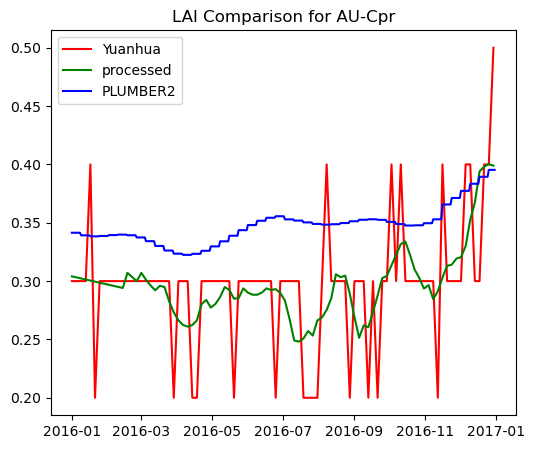

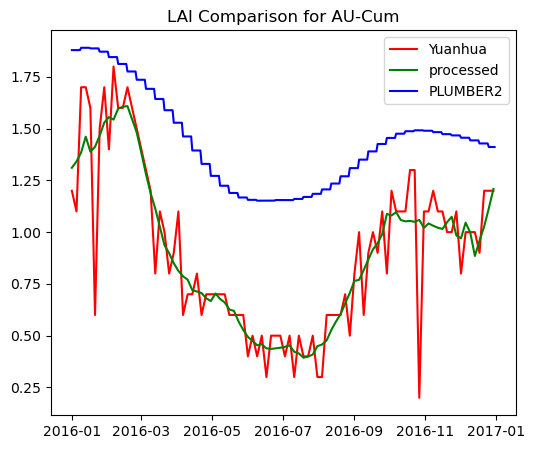

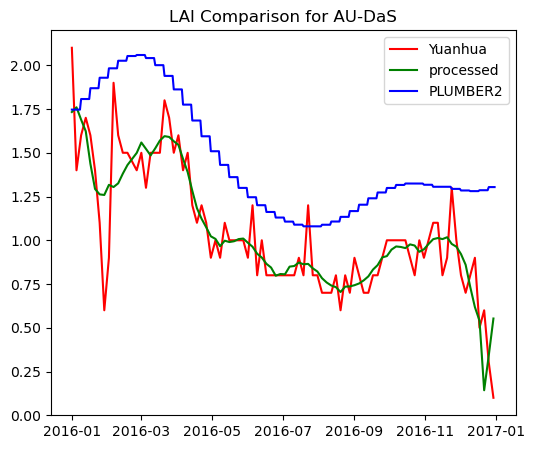

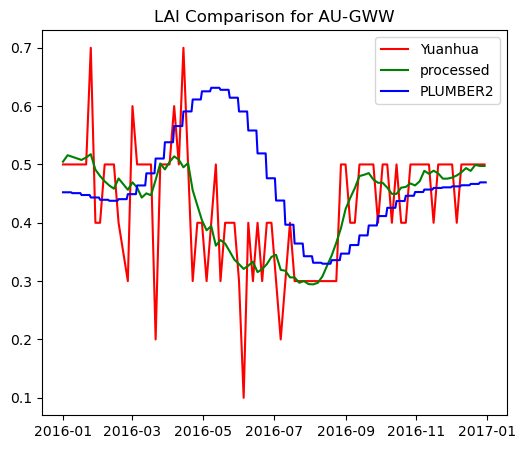

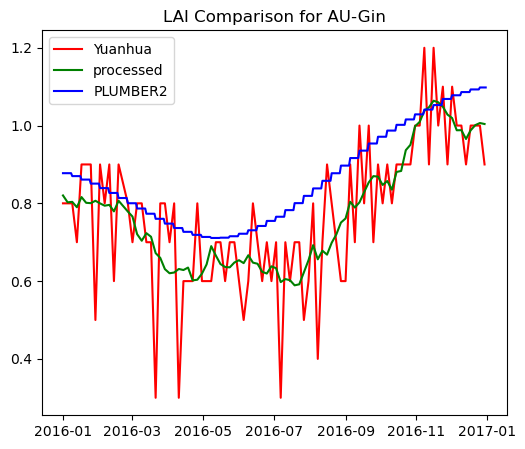

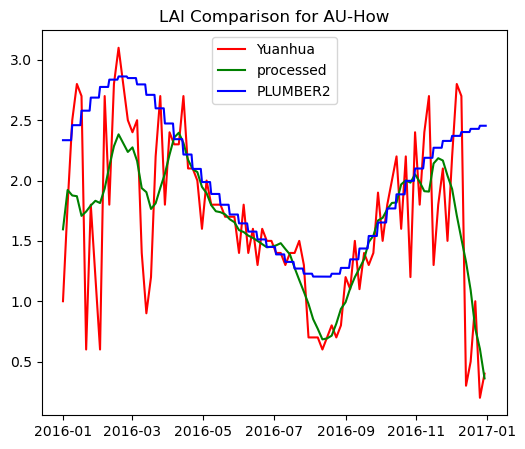

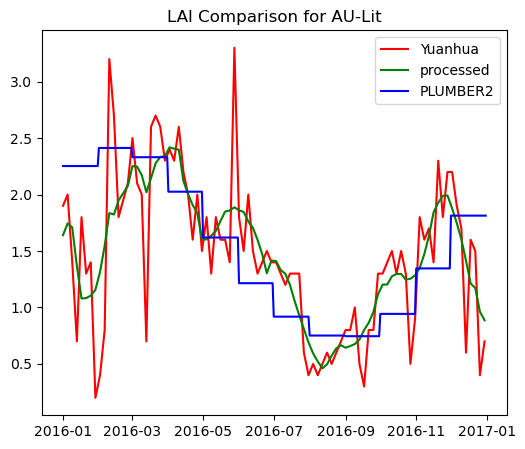

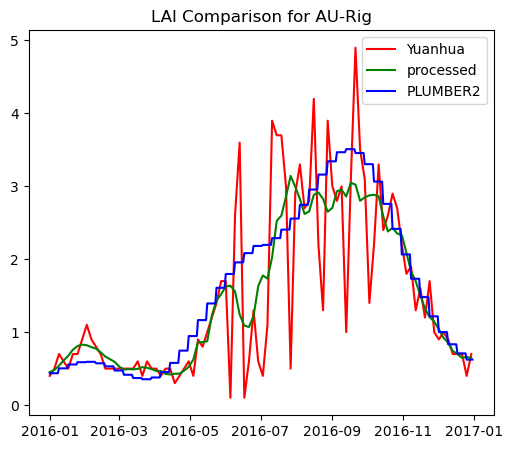

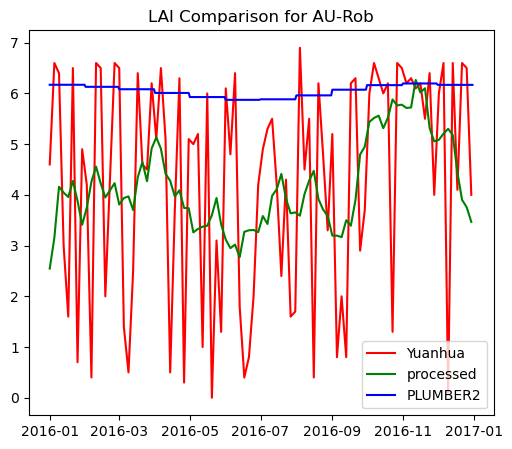

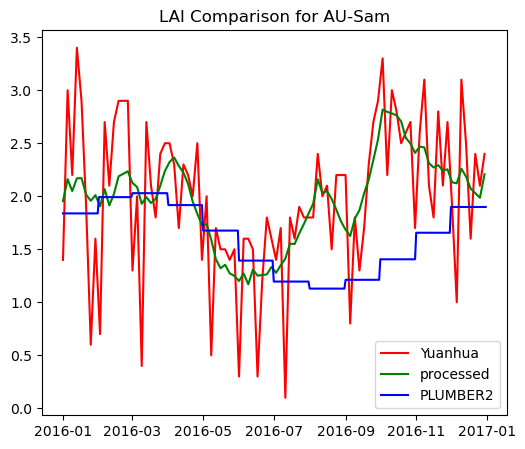

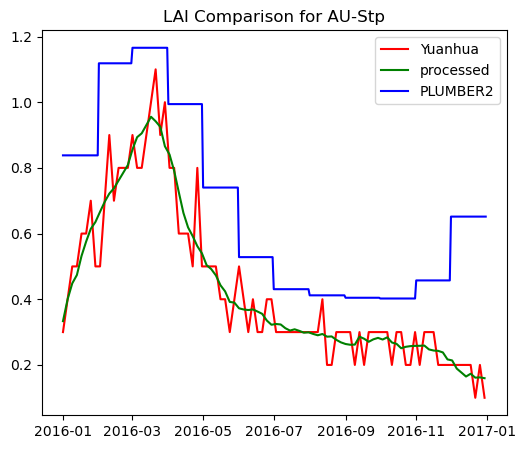

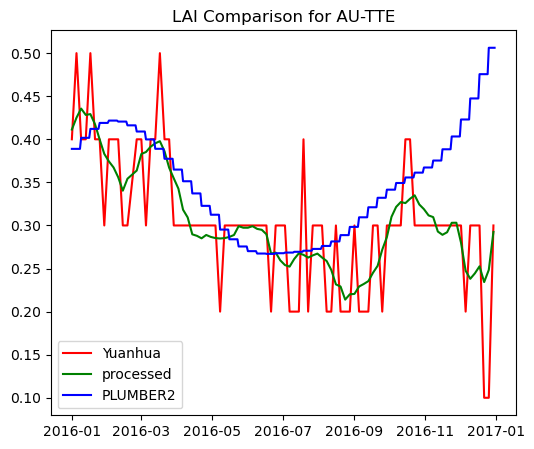

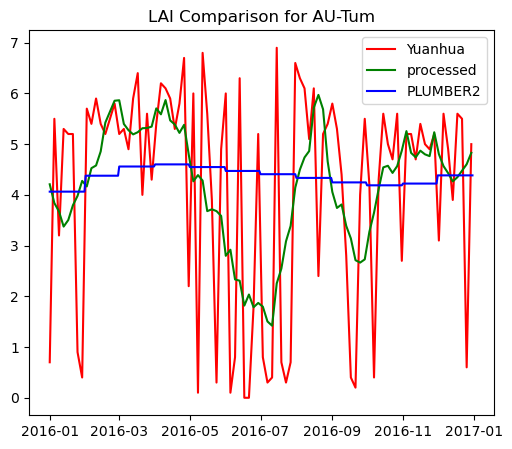

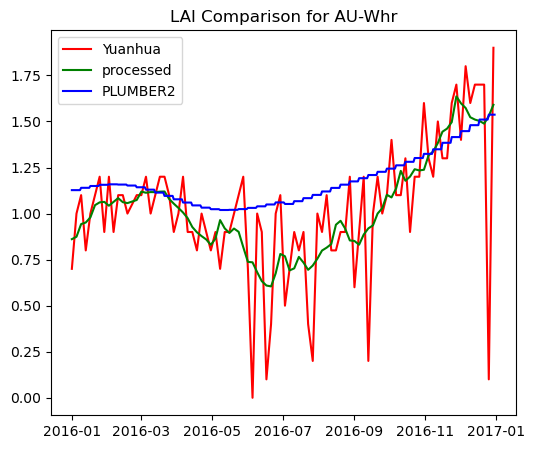

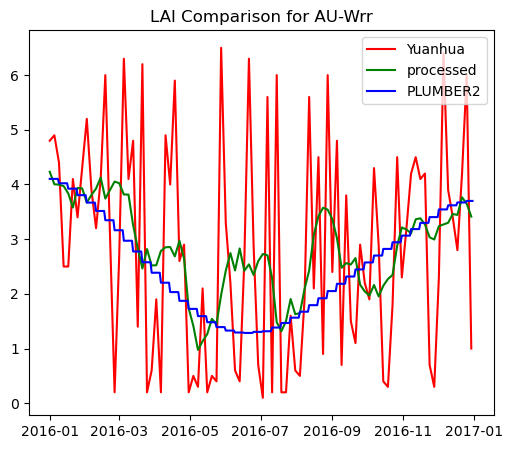

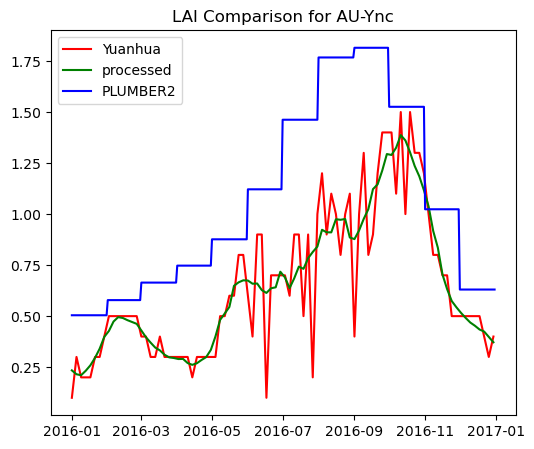

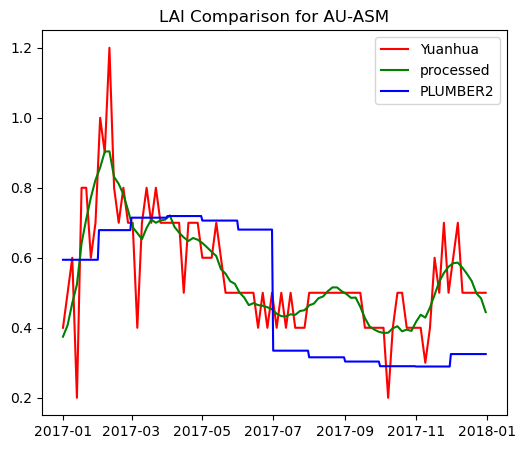

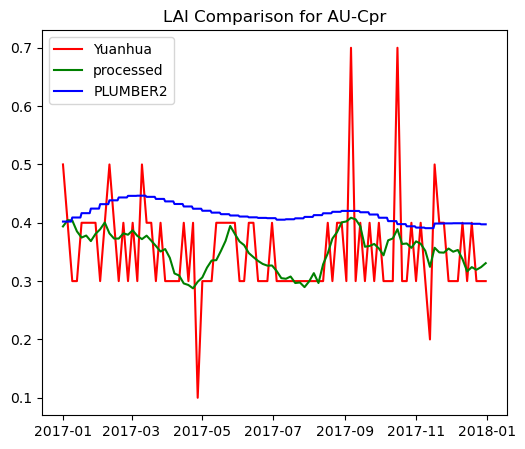

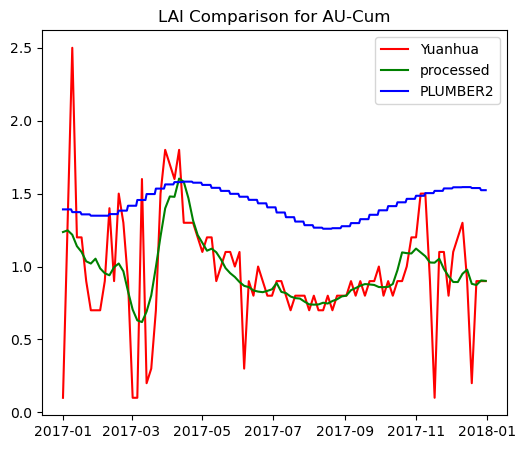

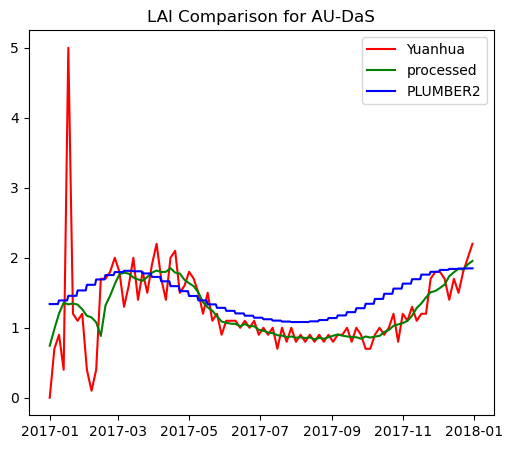

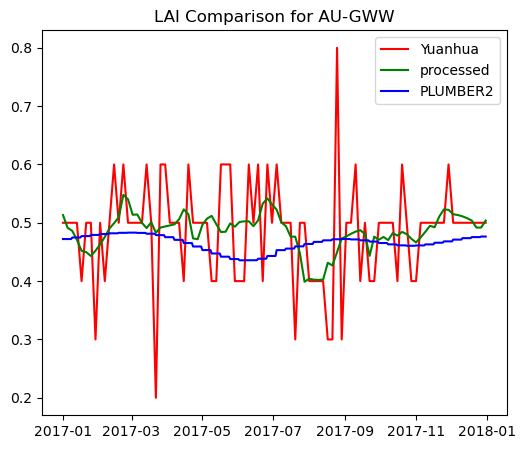

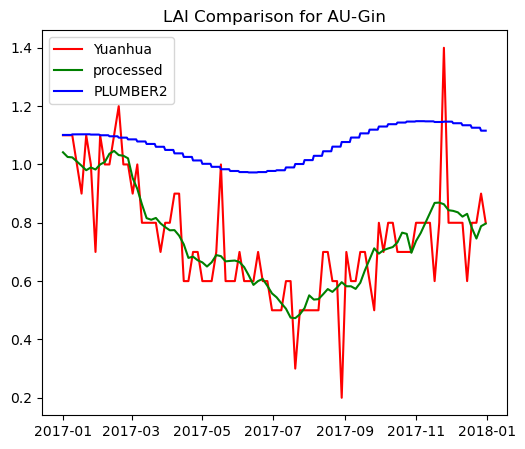

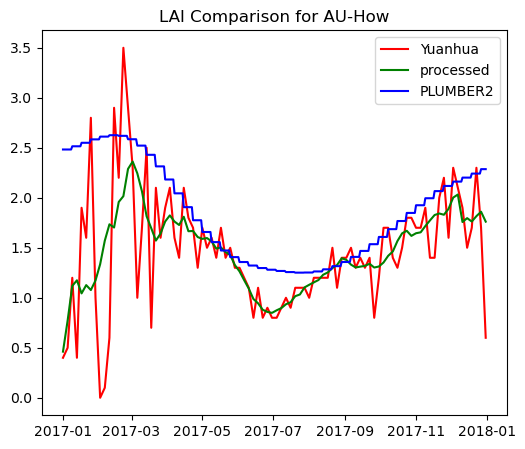

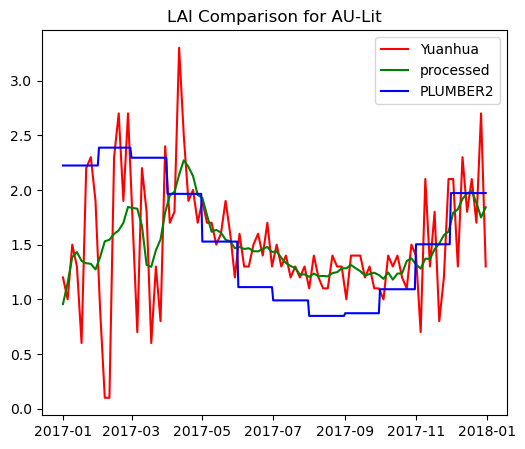

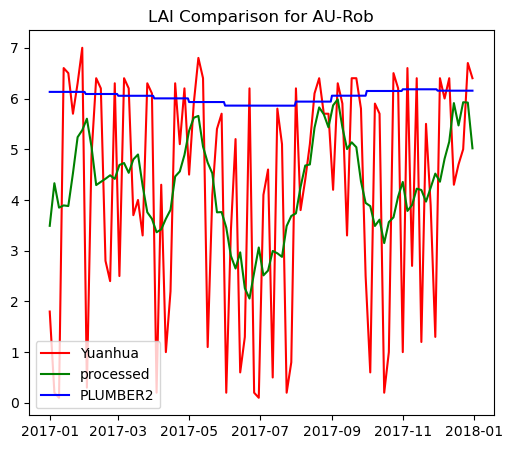

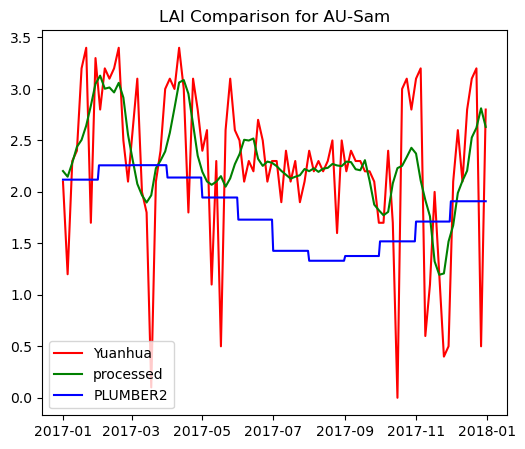

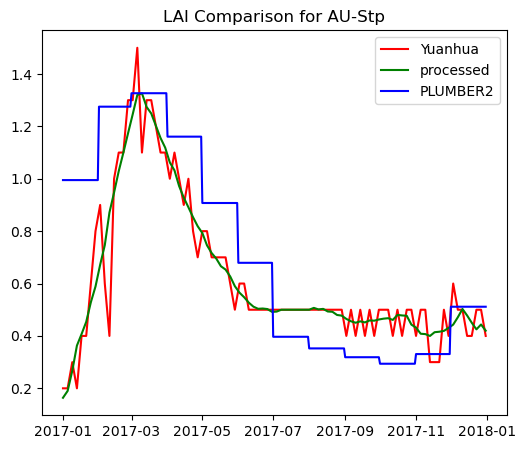

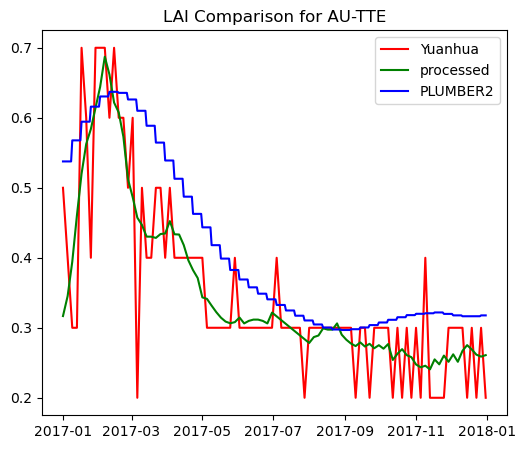

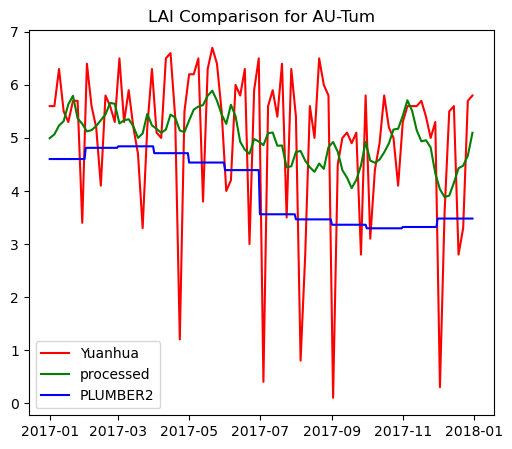

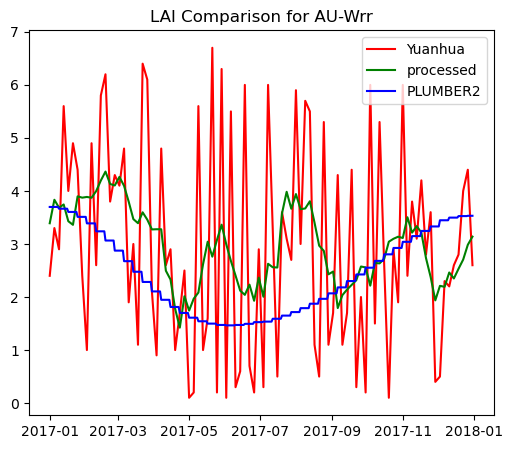

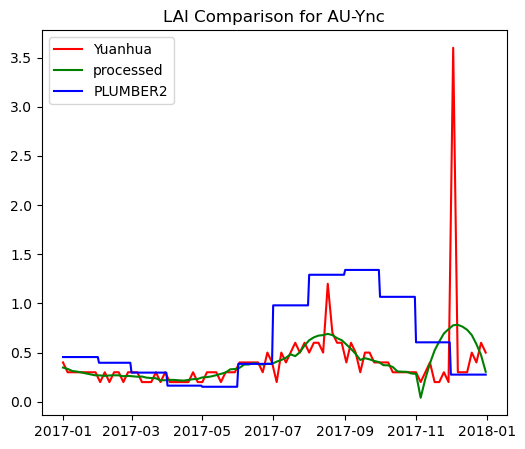

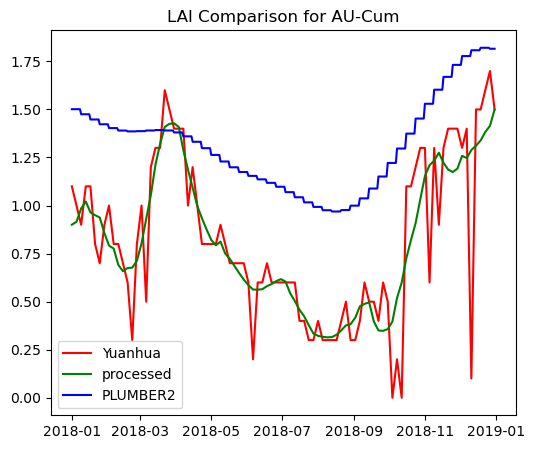

In [5]:
window_length = 15
polyorder     = 2

    
file_LAI_orig      = "/g/data/w97/mm3972/data/MODIS/MODIS_LAI/AUS/regrid_2_AWAP_5km/MCD15A3H.061_500m_aid0001_LAI_regridded_2002-2024.nc"
file_LAI_processed = f"/g/data/w97/mm3972/data/MODIS/MODIS_LAI/AUS/regrid_2_AWAP_5km/MCD15A3H.061_500m_aid0001_LAI_regridded_2002-2024_SG_filter_window=15timestep_order=2.nc"

f_LAI_orig         = nc.Dataset(file_LAI_orig)
f_LAI_processed    = nc.Dataset(file_LAI_processed)

LAI_orig           = f_LAI_orig.variables['Lai_500m'][:]
lat_orig           = f_LAI_orig.variables['latitude'][:]
lon_orig           = f_LAI_orig.variables['longitude'][:]
time_orig          = nc.num2date(f_LAI_orig.variables['time'][:],f_LAI_orig.variables['time'].units,
                     only_use_cftime_datetimes=False, only_use_python_datetimes=True)

LAI_processed      = f_LAI_processed.variables['Lai_500m'][:]
lat_processed      = f_LAI_processed.variables['latitude'][:]
lon_processed      = f_LAI_processed.variables['longitude'][:]

# Make time array for processed LAI  
start_date         = datetime(year, 1, 1, 0, 0)
end_date           = datetime(year, 12, 31, 0, 0)

# Create an array of datetime objects
# time_processed     = np.array([start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)])
time_processed     = nc.num2date(f_LAI_processed.variables['time'][:],f_LAI_processed.variables['time'].units,
                     only_use_cftime_datetimes=False, only_use_python_datetimes=True)

message            = 'Met'
PLUMBER2_path      = '/g/data/w97/mm3972/data/Fluxnet_data/Post-processed_PLUMBER2_outputs/Nc_files/Met'
PLUMBER2_AU_files  = [  f'AU-ASM_2011-2017_OzFlux_{message}.nc',      
                        f'AU-Cpr_2011-2017_OzFlux_{message}.nc',     
                        f'AU-Cum_2013-2018_OzFlux_{message}.nc',       
                        f'AU-DaP_2009-2012_OzFlux_{message}.nc',       
                        f'AU-DaS_2010-2017_OzFlux_{message}.nc',       
                        f'AU-Dry_2011-2015_OzFlux_{message}.nc',       
                        f'AU-Emr_2012-2013_OzFlux_{message}.nc',       
                        f'AU-GWW_2013-2017_OzFlux_{message}.nc',       
                        f'AU-Gin_2012-2017_OzFlux_{message}.nc',       
                        f'AU-How_2003-2017_OzFlux_{message}.nc',       
                        f'AU-Lit_2016-2017_OzFlux_{message}.nc',       
                        f'AU-Rig_2011-2016_OzFlux_{message}.nc',       
                        f'AU-Rob_2014-2017_OzFlux_{message}.nc',       
                        f'AU-Sam_2011-2017_OzFlux_{message}.nc',       
                        f'AU-Stp_2010-2017_OzFlux_{message}.nc',       
                        f'AU-TTE_2013-2017_OzFlux_{message}.nc',       
                        f'AU-Tum_2002-2017_OzFlux_{message}.nc',       
                        f'AU-Whr_2015-2016_OzFlux_{message}.nc',       
                        f'AU-Wrr_2016-2017_OzFlux_{message}.nc',       
                        f'AU-Ync_2011-2017_OzFlux_{message}.nc',
                        # f'AU-Otw_2009-2010_OzFlux_{message}.nc',     
                        # f'AU-Cow_2010-2015_OzFlux_{message}.nc',         
                        # f'AU-Ctr_2010-2017_OzFlux_{message}.nc',         
                        ]

site_characters    = pd.read_csv('/g/data/w97/mm3972/scripts/PLUMBER2/LSM_GPP_PLUMBER2/txt/site_character.csv')

# Correct filtering for Australian sites
au_site_characters = site_characters[site_characters['site_name'].str.contains('AU')]
au_site_list       = np.unique(au_site_characters['site_name'])


for year in np.arange(2016,2021):

    for PLUMBER2_AU_file in PLUMBER2_AU_files:

        site_name, lat, lon, df_LAI_P2  = get_PLUMBER2_lat_lon_LAI(PLUMBER2_AU_file, au_site_list, start_date, end_date)
        
        print(lat, lon, df_LAI_P2)
        
        if ~np.isnan(lat):
            # Get pixel LAI in Yuanhua's file
            # Find the indices of the nearest pixels to lat and lon.
            lat_idx_orig      = np.argmin(np.abs(lat_orig - lat))
            lon_idx_orig      = np.argmin(np.abs(lon_orig - lon))

            # Read the climate_class value of the nearest pixel.
            df_LAI_orig_tmp   = pd.DataFrame(LAI_orig[:, lat_idx_orig, lon_idx_orig].data, columns=['LAI'])

            # Subset CABLE data to match PLUMBER2 time range
            df_LAI_orig        = df_LAI_orig_tmp[(time_orig >= start_date) & (time_orig <= end_date)]
            df_LAI_orig['time']= time_orig[(time_orig >= start_date) & (time_orig <= end_date)]

            # Get pixel LAI in my file
            # Find the indices of the nearest pixels to lat and lon.
            lat_idx_processed    = np.argmin(np.abs(lat_processed - lat))
            lon_idx_processed    = np.argmin(np.abs(lon_processed - lon))

            # Read the climate_class value of the nearest pixel.
            df_LAI_processed_tmp = pd.DataFrame(LAI_processed[:, lat_idx_processed, lon_idx_processed].data, columns=['LAI'])

            # Subset CABLE data to match PLUMBER2 time range
            df_LAI_processed        = df_LAI_processed_tmp[(time_processed >= start_date) & (time_processed <= end_date)]
            df_LAI_processed['time']= time_processed[(time_processed >= start_date) & (time_processed <= end_date)]

            
            # ================== Start Plotting =================
            fig, ax  = plt.subplots(figsize=(6,5))

            # Plot comparison of Qle for CABLE and PLUMBER2
            print(len(df_LAI_orig['time']), len(df_LAI_processed['time']), len(df_LAI_P2['time']))
            
            ax.plot(df_LAI_orig['time'],      df_LAI_orig['LAI'].values, c='red', label='Yuanhua')
            ax.plot(df_LAI_processed['time'], df_LAI_processed['LAI'].values, c='green', label='processed')
            ax.plot(df_LAI_P2['time'],        df_LAI_P2['LAI'].values, c='blue', label='PLUMBER2')
            ax.legend()
            ax.set_title(f'LAI Comparison for {site_name}')

            plt.savefig(f'/g/data/w97/mm3972/scripts/Land_Drought_Rainfall/plots/Check_LAI/Check_SG_LAI_{site_name}_{year}_{window_length}_{polyorder}.png',dpi=300)